In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [2]:
def coefficients(e, c0, p0, Ka, Kc):
    d = c0**2 * e * Ka
    c = -c0**2 * Ka + c0 * e * (-2 * Ka + Kc) - c0 * Kc * p0
    b = -c0 * (-2 * Ka + Kc) + e * (Ka + (-1 + Kc) * Kc) - Kc * (-1 + 2 * Kc) * p0
    a = -Ka - (-1 + Kc) * Kc
    return(np.array([a, b, c, d]))

def  my_cubic_solve(array):
    roots = np.roots(array)
    real_roots = []
    for i in roots:
        if (i.imag == 0):
            real_roots.append(i.real)
    return (np.array(real_roots))

def tdmc(cp, c0, p0, Ka, Kc):
    c = c0  -  cp
    t = (cp**2  *  Kc**2  *  p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    d = ((c0 - cp) * cp * Kc * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    m = ((c0 - cp)**2 * Ka * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    return(t, d, m, c)

def equilibr_ck(k, c0, t, d):
    crp = c0 * t / (d * k + t)
    cr = c0 - crp
    return (cr, crp)

def tdm(p, z):
    atp = ( 3*z + p - (p*p + 6*p*z - 3*z*z)**0.5 ) / 6
    adp = z - 2*atp
    amp = p - z + atp
    return(atp, adp, amp)

def u_atpase(a, atp):
    return (a * atp)

def u_hk(a, atp, g6p):
	return (a * (atp/1) / (1 + atp/1 + g6p/0.0055))

def u_pgi(a, g6p, f6p):
	k1, k2, k3 = 3, 0.3, 0.2
	return (a * (g6p-f6p*k1)/k2/(1+g6p/k2+f6p/k3))

def u_pfk(a, atp, amp, f6p):
	az = (1+atp/0.195)/(1+amp/0.01)/(1+f6p/3.7e-4)
	zn = 1 + 1e8 * az**4
	ch = a * f6p / (f6p+0.1) * atp/(atp+2) * (1/(1+amp/0.01)+2*amp/(amp+0.01))
	return (1.1 * ch/zn)

def u_ald(a, fdp, dap, gap):
	k1, k2, k3 = 2e-4, 1.2e-5, 1e-2
	k4, k5, k6, k7 = 3.2e-2, 2.1e-3, 2, 6.5e-2
	x = fdp/k1 - dap*gap/k2
	y = 1 + fdp/k3 + dap/k4 + gap/k5 + fdp*dap/k3/k4 + dap*dap/k4/k6 + dap*gap/k4/k7
	return (a * x / y)
	# Aald_eff = Aald * k3 * k4 / (k1 * (DAP + k4))

def u_tpi(a, dap, gap):
	k1, k2, k3 = 8.2e-1, 0.45, 4.3e-1
	return (a*(dap-gap/k2)/k1/(1+dap/k1+gap/k3))

def u_gapd(a, gap, nad, pi, dpg13, nadh):
	k1, k2, k3 = 0.13, 0.13, 3.4
	k4, k5, k6 = 0.136, 1.25e-2, 2e-3
	tt1 = a * (gap*nad*pi - dpg13*nadh/k4)/k1/k2/k3
	tt2 = (1+pi/k3)*(1+gap/k1+dpg13/k5)*(1+nad/k2+nadh/k6)
	return (tt1/tt2)
	# Эффективная активность GAPD при данных NADH, NAD, PI в сторону образования 1,3ДФГ
	# Agapd_eff = (Agapd * k6 * NAD * PI) / (k6 * NAD + k2 * (k6 + NADH)) / (k3 + PI)

def u_pgk(a, dpg13, adp, pg3, atp):
	ch1 = a * (dpg13*adp - pg3*atp/380)/2.2E-3/0.14
	aa = (0.3 + adp + 0.3*atp/0.27) / 0.14
	ab = (0.4 + atp + adp*0.4/0.14) / 0.27
	zn1 = (1 + atp/0.27 + adp/0.14 + aa*dpg13/2.2E-3 + ab*pg3/1.4)
	return (ch1 / zn1)

def u_pgm(a, pg3, pg2):
	k1, k2, k3 = 0.27, 0.24, 2e-2
	return (a * (pg3 - pg2/k2) / k1 / (1 + pg3/k1 + pg2/k3))

def u_eno(a, pg2, pep):
	# Старый вариант из статьи Эрлих 1985. ЕНО здесь была практически необратимая
	# k1, k2, k3 = 5.6e-2, 6.7, 2e-3
	k1, k2, k3 = 28e-3, 5, 50e-3 # обновил параметры из литературы
	return (a * (pg2 - pep/k2) / k1 / (1 + pg2/k1 + pep/k3))

def u_pk(a, pep, adp, atp):
	k2 = 0.415
	ch = a * pep*adp/0.05/k2
	zn = 1 + pep/0.05 + adp/k2 + atp/0.35 + pep*adp/0.05/k2
	return (ch / zn)

def u_ld(a, pyr, nadh, lac, nad):
	k1, k2, k3 = 2.2e-2, 7e-3, 426
	k4, k5, k6, k7 = 1.4e-1, 380, 0.1, 170
	temp1 = (pyr*nadh - lac*nad/k3)/k1/k2
	temp2 = k7*nad + k6*lac + nad*lac + k7/k1*pyr*nad
	temp3 = 1 + pyr/k1 + (nadh*k4 + pyr*nadh + k4/k5*lac*nadh)/k1/k2 + temp2/k5/k6
	return (a * temp1/temp3)

def u_gp_a(a, pi, g1p):
	kp, kg, keq = 4, 2.7, 1/3
	# local keq = 1/12
	return (a * kg * (pi - g1p / keq) / (kg * kp + kg * pi + kp * g1p))


def u_gp_b(a, pi, g1p, amp):
	
	keq = 1/3 
	
	# local kp = 4 * (amp + 0.1) / 1.1 / amp
	# local kg = 2.7 * (amp + 0.1) / 2 / amp
	# local af = a * amp / (amp + 0.02)
	# return af * (pi * keq - g1p) / (kp * g1p + kg * pi + kp * kg)
	
	# local a, b = 7.2, 1.26
	# local c, d = 0.203, 0.7
	# local e, f = 22.7, 0.0139
	# local kp = a / amp + b
	# local kg = c / amp + d
	# local ar = e * amp / (amp + f)
	# local arn = ar / e
	# return a * arn * kp * (keq * pi - g1p) / (kp * g1p + kg * pi + kp * kg) 

	kg = 0.172 / amp + 1.11
	ar = amp / (amp + 0.0104)
	return (ar / kg * ( keq * pi - g1p ))



def u_pgcm(a, g1p, g6p):
	k1, k6, keq = 8.5e-3, 50e-3, 17
	return (a * k6 * (g1p - g6p / keq) / (k1 * k6 + k6 * g1p + k1 * g6p))

def u_gp_a_palm(a, pi, g1p, g6p, amp):
	n = 2
	krpi = 2.08
	krg1p = 0.67
	kramp = 3.4e-3
	krg6p = 7.4
	lu = 5.9
	kupi = 4.3
	kug1p = 82
	kug6p = 0.56
  
	v1 = a*n*pi/krpi*(1 + pi/krpi + g1p/krg1p)**(n - 1)
	v2 = (1 + pi/krpi + g1p/krg1p)**n + lu*(1 + pi/kupi + g1p/kug1p)**n*(1 + g6p/kug6p)**n/(1 + amp/kramp + g6p/krg6p)**n

	return (a * v1 / v2)

In [3]:
def func(y):    
    
    f6p_ = y[0]
    fdp_ = y[1]
    dap_ = y[2]
    gap_ = y[3]
    dpg13_ = y[4]
    pg3_ = y[5]
    pg2_ = y[6]
    pep_ = y[7]
    nadh_ = y[8]
    ep_ = y[9]
    g6p_ = y[10]
    g1p_ = y[11]
    
    nad = nad_0 - nadh_
    po4_up = g1p_ + g6p_ + f6p_ + 2*fdp_ + dap_ + gap_
    po4_down = 2*dpg13_ + pg3_ + pg2_ + pep_
    po4 = po4_0 - ( po4_up + po4_down + ep_)
#     print(my_cubic_solve(coefficients(ep_, c_0, p_0, k_ak, k_ck)))
    crp = float(my_cubic_solve(coefficients(ep_, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    

    return(u_pgi(a_pgi, g6p_, f6p_) - u_pfk(a_pfk, atp, amp, f6p_),
           u_pfk(a_pfk, atp, amp, f6p_) - u_ald(a_ald, fdp_, dap_, gap_),
           u_ald(a_ald, fdp_, dap_, gap_) - u_tpi(a_tpi, dap_, gap_),
           u_tpi(a_tpi, dap_, gap_) + u_ald(a_ald, fdp_, dap_, gap_) - u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_),
           u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp),
           u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) - u_pgm(a_pgm * ACT, pg3_, pg2_),
           u_pgm(a_pgm * ACT, pg3_, pg2_) - u_eno(a_eno * ACT, pg2_, pep_),
           u_eno(a_eno * ACT, pg2_, pep_) - u_pk(a_pk * ACT, pep_, adp, atp),
           u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_ld(a_ld * ACT, pyr, nadh_, lac, nad),
           -u_hk(a_hk, atp, g6p_) - u_pfk(a_pfk, atp, amp, f6p_)+ u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) + u_pk(a_pk * ACT, pep_, adp, atp) - u_atpase(a_atpase, atp),
           u_hk(a_hk, atp, g6p_) - u_pgi(a_pgi, g6p_, f6p_) + u_pgcm(a_pgcm, g1p_, g6p_),
           u_gp_a(a_gp_a, po4, g1p_) - u_pgcm(a_pgcm, g1p_, g6p_))




# Решим дифур и найдем стационарное состояние. Это будет начальное решение системы.

In [4]:
from scipy.integrate import odeint
from sympy import symbols, Eq, solve

ДУ

In [5]:
#y0 = [f6p, fdp, dap, gap, dpg13, pg3, pg2, pep, nadh, ep, g6p, g1p]


def right_part(y, t):
    dy = np.zeros(len(y))
    
    f6p_ = y[0]
    fdp_ = y[1]
    dap_ = y[2]
    gap_ = y[3]
    dpg13_ = y[4]
    pg3_ = y[5]
    pg2_ = y[6]
    pep_ = y[7]
    nadh_ = y[8]
    ep_ = y[9]
    g6p_ = y[10]
    g1p_ = y[11]

    nad = nad_0 - nadh_
    po4_up = g1p_ + g6p_ + f6p_ + 2*fdp_ + dap_ + gap_
    po4_down = 2*dpg13_ + pg3_ + pg2_ + pep_
    po4 = po4_0 - ( po4_up + po4_down + ep_)
    crp = float(my_cubic_solve(coefficients(ep_, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    
    dy[0] = u_pgi(a_pgi, g6p_, f6p_) - u_pfk(a_pfk, atp, amp, f6p_)
    dy[1] = u_pfk(a_pfk, atp, amp, f6p_) - u_ald(a_ald, fdp_, dap_, gap_)
    dy[2] = u_ald(a_ald, fdp_, dap_, gap_) - u_tpi(a_tpi, dap_, gap_)
    dy[3] = u_tpi(a_tpi, dap_, gap_) + u_ald(a_ald, fdp_, dap_, gap_) - u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_)
    dy[4] = u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp)
    dy[5] = u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) - u_pgm(a_pgm * ACT, pg3_, pg2_)
    dy[6] = u_pgm(a_pgm * ACT, pg3_, pg2_) - u_eno(a_eno * ACT, pg2_, pep_)
    dy[7] = u_eno(a_eno * ACT, pg2_, pep_) - u_pk(a_pk * ACT, pep_, adp, atp)
    dy[8] = u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_ld(a_ld * ACT, pyr, nadh_, lac, nad)
    dy[9] = -u_hk(a_hk, atp, g6p_) - u_pfk(a_pfk, atp, amp, f6p_)+ u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) + u_pk(a_pk * ACT, pep_, adp, atp) - u_atpase(a_atpase, atp)
    dy[10] = u_hk(a_hk, atp, g6p_) - u_pgi(a_pgi, g6p_, f6p_) + u_pgcm(a_pgcm, g1p_, g6p_)
    dy[11] = u_gp_a(a_gp_a, po4, g1p_) - u_pgcm(a_pgcm, g1p_, g6p_)
    
    return(dy)

НУ

In [826]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

a_gp_a, a_gp_b = 5000, 5000
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10
#v_0 = 500

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1


nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [827]:
ep

33.10863556545557

In [828]:
# ep = 2 * p_0 + c_0 - 10
# po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [829]:
y0 = [f6p, fdp, dap, gap, dpg13, pg3, pg2, pep, nadh, ep, g6p, g1p]

In [830]:
t = np.linspace(0,20,1000)
a_gp_a = 5000

In [831]:
#a_atpase = 0

In [832]:
a_atpase = 5.5
res = odeint(right_part,y0,t)

In [833]:
f6p = np.array(res)[:,0]
fdp = np.array(res)[:,1]
dap = np.array(res)[:,2]
gap = np.array(res)[:,3]
dpg13 = np.array(res)[:,4]
pg3 = np.array(res)[:,5]
pg2 = np.array(res)[:,6]
pep = np.array(res)[:,7]
nadh = np.array(res)[:,8]
ep = np.array(res)[:,9]
g6p = np.array(res)[:,10]
g1p = np.array(res)[:,11]

In [834]:
atp_t = []
adp_t = []
amp_t = []
po4_t = []
crp_t = []
ep_t = []
po4_up_t = []
po4_down_t = []
for i in range(len(t)):
    nad = nad_0 - nadh[i]
    po4_up = g1p[i] + g6p[i] + f6p[i] + 2*fdp[i] + dap[i] + gap[i]
    po4_down = 2*dpg13[i] + pg3[i] + pg2[i] + pep[i]
    po4 = po4_0 - ( po4_up + po4_down + ep[i] )
    crp = float(my_cubic_solve(coefficients(ep[i], c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    atp_t.append(atp)
    adp_t.append(adp)
    amp_t.append(amp)
    po4_t.append(po4)
    crp_t.append(crp)
    ep_t.append(2 * atp + adp + crp)
    po4_up_t.append(po4_up)
    po4_down_t.append(po4_down)

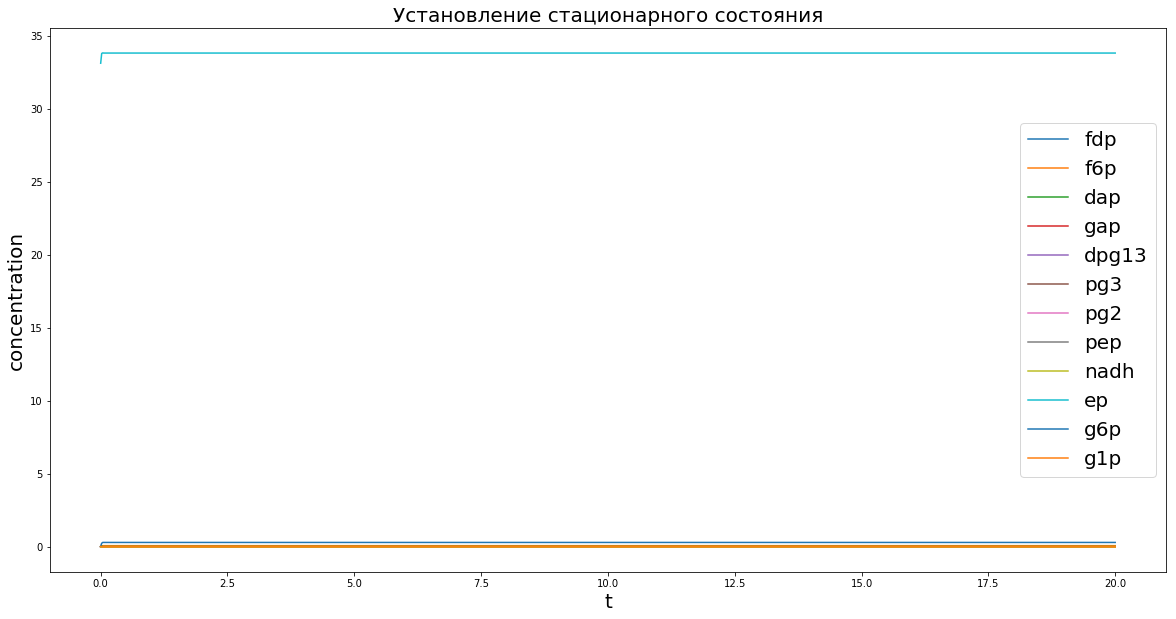

In [835]:
plt.figure(figsize = (20, 10))
plt.plot(t,fdp)
plt.plot(t,f6p)
plt.plot(t,dap)
plt.plot(t,gap)
plt.plot(t,dpg13)
plt.plot(t,pg3)
plt.plot(t,pg2)
plt.plot(t,pep)
plt.plot(t,nadh)
plt.plot(t,ep)
plt.plot(t,g6p)
plt.plot(t,g1p)
plt.legend(['fdp',\
            'f6p', \
            'dap', \
            'gap', \
            'dpg13', \
            'pg3', \
            'pg2', \
            'pep', \
            'nadh', \
            'ep',\
            'g6p',\
            'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

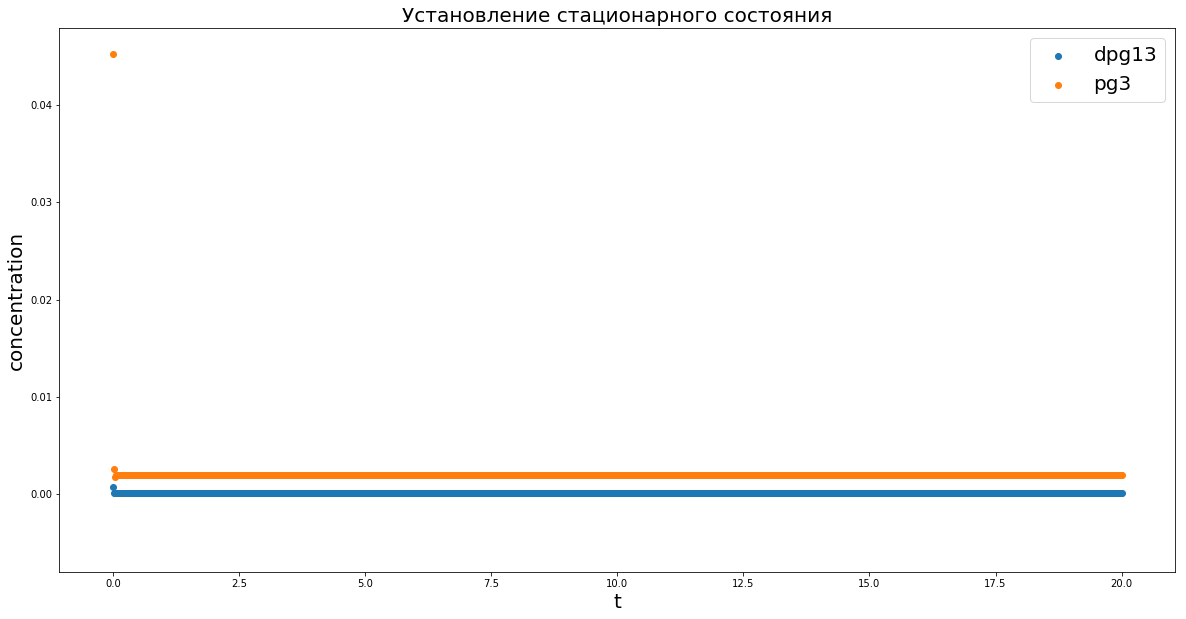

In [836]:
plt.figure(figsize = (20, 10))
#plt.plot(t,fdp)
#plt.plot(t,f6p)
#plt.plot(t,dap)
#plt.plot(t,gap)
plt.scatter(t,dpg13)
plt.scatter(t,pg3)
#plt.plot(t,pg2)
#plt.plot(t,pep)
#plt.plot(t,nadh)
#plt.plot(t,ep)
#plt.plot(t,g6p)
#plt.plot(t,g1p)
plt.legend([#'fdp',\
            #'f6p', \
            #'dap', \
            #'gap', \
            'dpg13', \
            'pg3', \
            #'pg2', \
            #'pep', \
            #'nadh', \
            #'ep',\
            #'g6p',\
            #'g1p', \
    ], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

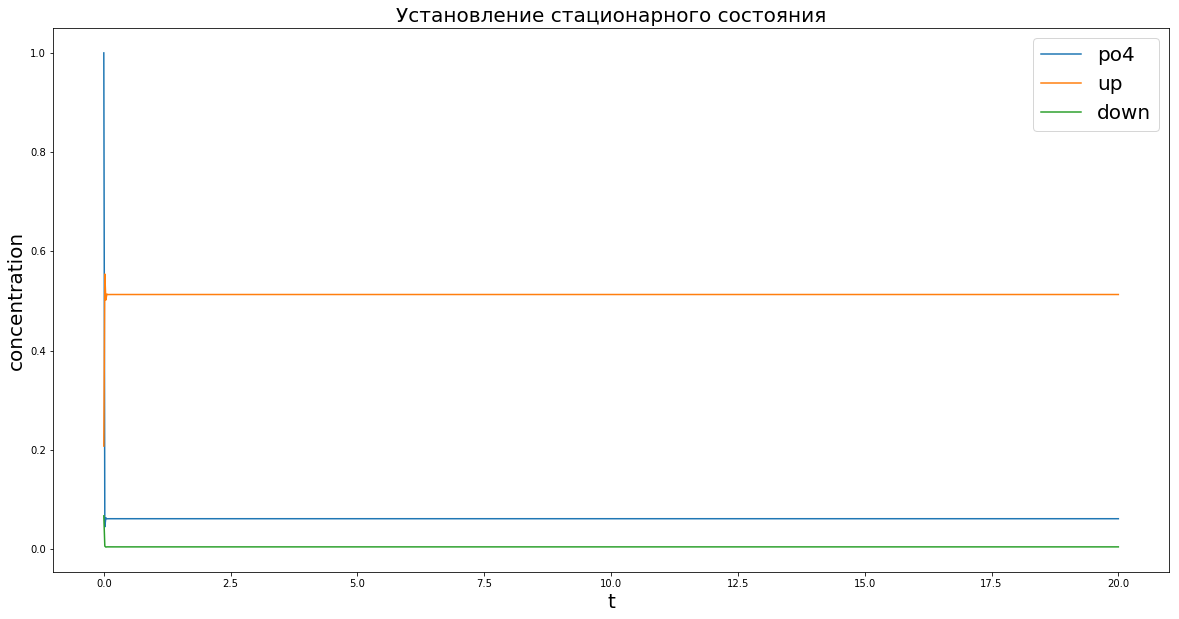

In [837]:
plt.figure(figsize = (20, 10))
plt.plot(t,po4_t)
plt.plot(t,po4_up_t)
plt.plot(t,po4_down_t)

plt.legend(['po4', 'up', 'down'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

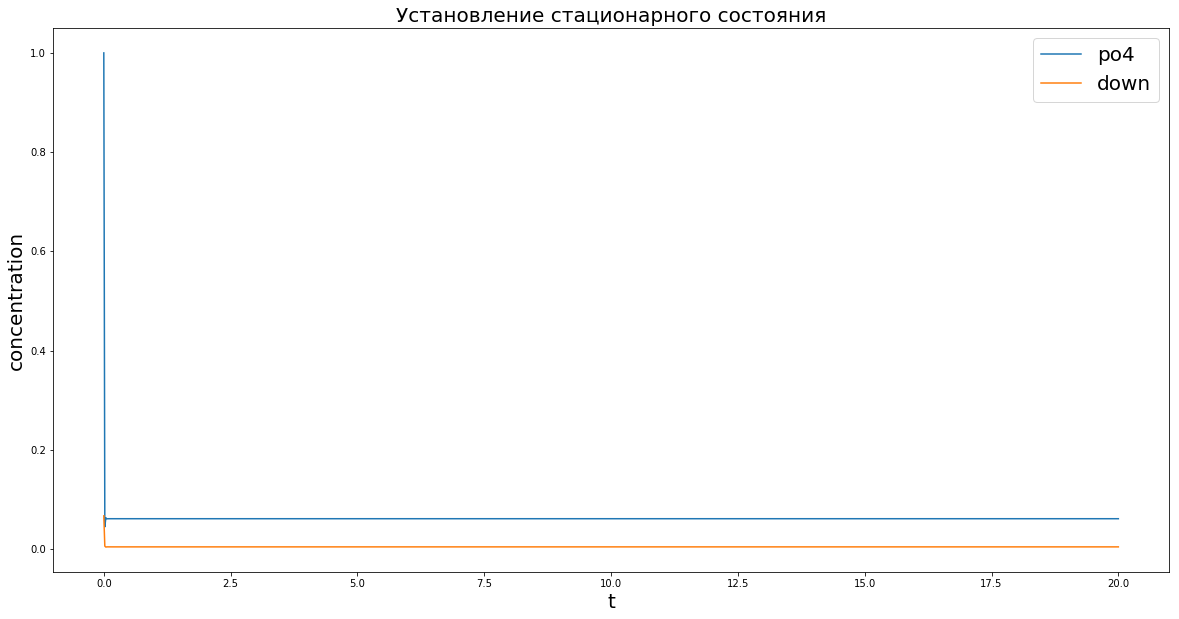

In [838]:
plt.figure(figsize = (20, 10))
plt.plot(t,po4_t)
#plt.plot(t,po4_up_t)
plt.plot(t,po4_down_t)

plt.legend(['po4', \
            #'up', \
            'down'\
           ], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

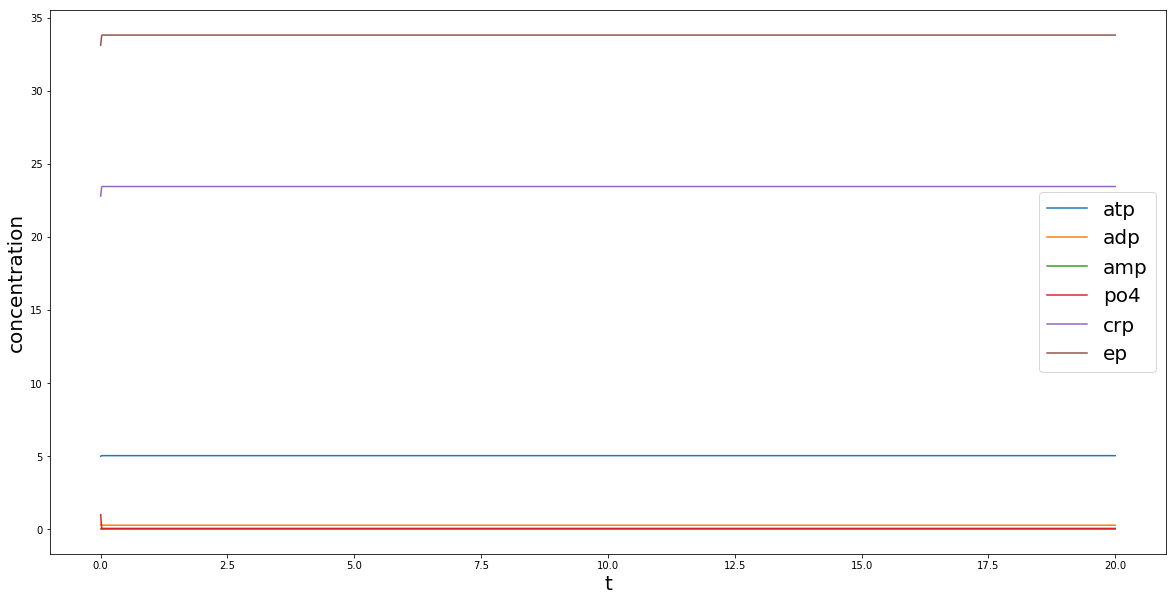

In [839]:
plt.figure(figsize = (20, 10))
plt.plot(t,atp_t)
plt.plot(t,adp_t)
plt.plot(t,amp_t)
plt.plot(t,po4_t)
plt.plot(t,crp_t)
plt.plot(t,ep_t)
plt.legend(['atp', 'adp', 'amp', 'po4', 'crp', 'ep'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(0, 1)
#plt.ylim(-5, 100)
plt.ylabel('concentration', size = 20)
plt.show()

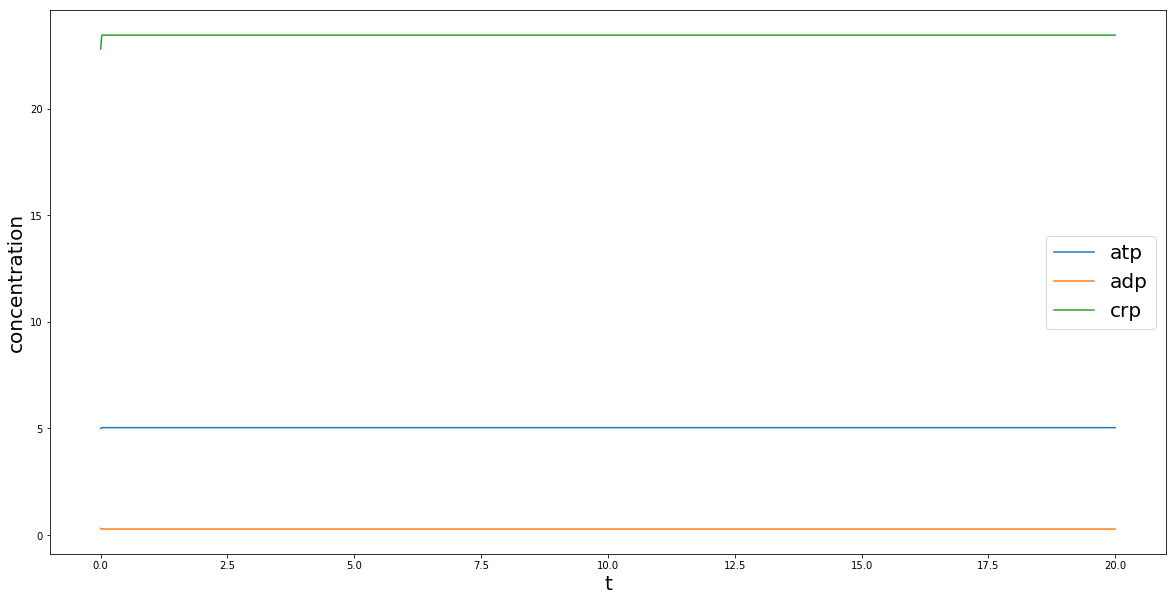

In [840]:
plt.figure(figsize = (20, 10))
plt.plot(t,atp_t)
plt.plot(t,adp_t)
plt.plot(t,crp_t)
plt.legend(['atp', 'adp', 'crp'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

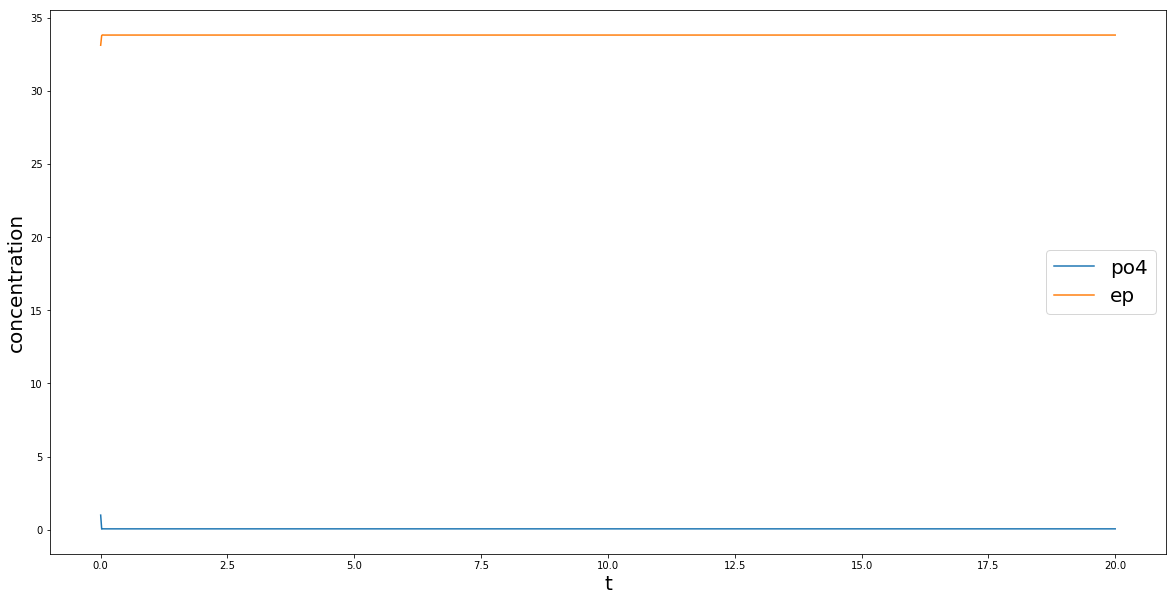

In [841]:
plt.figure(figsize = (20, 10))
plt.plot(t,po4_t)
plt.plot(t,ep_t)
plt.legend(['po4', 'ep'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

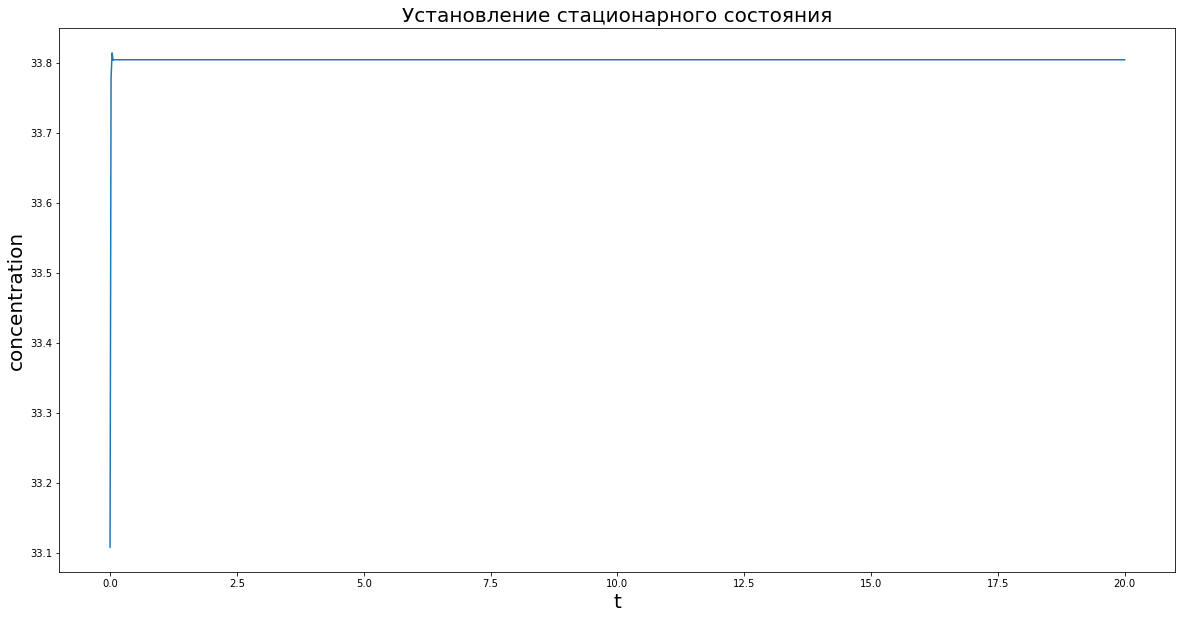

In [842]:
plt.figure(figsize = (20, 10))

plt.plot(t,ep)

#plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'ep','g6p', 'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('t', size = 20)
#plt.xlim(8, 10)
#plt.ylim(0, 5)
plt.ylabel('concentration', size = 20)
plt.show()

In [843]:
y0_de = [f6p[-1], fdp[-1], dap[-1], gap[-1], dpg13[-1], pg3[-1], pg2[-1], pep[-1], nadh[-1], ep[-1], g6p[-1], g1p[-1]]

In [844]:
 u_atpase(1, atp)

5.038722376495539

In [845]:
atpase_act = np.linspace(5.5, 1200, 10000)

In [846]:
a_gp_a = 5000 #!!!!!!

In [847]:
print(a_atpase)
res = [y0_de]
atp_p = []
adp_p = []
amp_p = []
po4_p = []
# nad = nad_0 - nadh[-1]
# po4_up = g1p[-1] + g6p[-1] + f6p[-1] + 2*fdp[-1] + dap[-1] + gap[-1]
# po4_down = 2*dpg13[-1] + pg3[-1] + pg2[-1] + pep[-1]
# po4 = po4_0 - ( po4_up + po4_down + ep[-1] )
# crp = float(my_cubic_solve(coefficients(ep[-1], c_0, p_0, k_ak, k_ck)))
# atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
nad = nad_0 - res[-1][8]
po4_up = res[-1][11] + res[-1][10] + res[-1][0] + 2*res[-1][1] + res[-1][2] +res[-1][3]
po4_down = 2*res[-1][4] + res[-1][5] + res[-1][6] + res[-1][7]
po4 = po4_0 - ( po4_up + po4_down + ep )
crp = float(my_cubic_solve(coefficients(res[-1][9], c_0, p_0, k_ak, k_ck)))
atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
root = fsolve(func, res[-1], full_output = True)

5.5


In [848]:
root[3]

'The solution converged.'

In [849]:
res = [y0_de]
atp_p = []
adp_p = []
amp_p = []
po4_p = []
ep = ep[-1]
ATPase_act = []
for a_atpase in atpase_act:
    
    nad = nad_0 - res[-1][8]
    po4_up = res[-1][11] + res[-1][10] + res[-1][0] + 2*res[-1][1] + res[-1][2] +res[-1][3]
    po4_down = 2*res[-1][4] + res[-1][5] + res[-1][6] + res[-1][7]
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    
    root = fsolve(func, res[-1], full_output = True)
    if (root[2] == 1):
        res.append(root[0])
        ep = root[0][9]
        atp_p.append(atp)
        adp_p.append(adp)
        amp_p.append(amp)
        po4_p.append(po4)
        ATPase_act.append(a_atpase)
        
    else:
        print(root[3])

In [850]:
res[-1][0]

0.015117741549233477

In [851]:
list(res[1]) == res[0]

True

In [852]:
f6p = np.array(res)[1:,0]
fdp = np.array(res)[1:,1]
dap = np.array(res)[1:,2]
gap = np.array(res)[1:,3]
dpg13 = np.array(res)[1:,4]
pg3 = np.array(res)[1:,5]
pg2 = np.array(res)[1:,6]
pep = np.array(res) [1:,7]
nadh = np.array(res)[1:,8]
ep = np.array(res)[1:,9]
g6p = np.array(res)[1:,10]
g1p = np.array(res)[1:,11]

In [853]:
ep

array([33.80428826, 33.80069479, 33.79712383, ...,  6.36073864,
        6.36032354,  6.35990851])

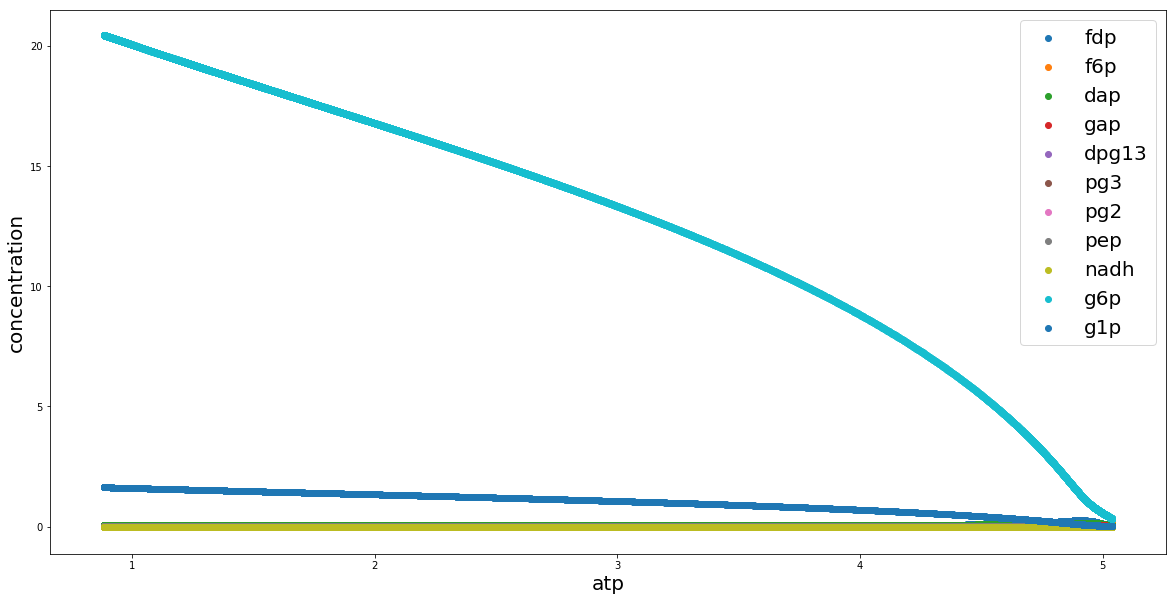

In [854]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,fdp)
plt.scatter(atp_p,f6p)
plt.scatter(atp_p,dap)
plt.scatter(atp_p,gap)
plt.scatter(atp_p,dpg13)
plt.scatter(atp_p,pg3)
plt.scatter(atp_p,pg2)
plt.scatter(atp_p,pep)
plt.scatter(atp_p,nadh)
plt.scatter(atp_p,g6p )
plt.scatter(atp_p,g1p )
plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atp', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

In [855]:
# atp_p_0 = atp_p
# atp_p_50 = atp_p
# atp_p_100 = atp_p
# atp_p_200 = atp_p
# atp_p_300 = atp_p
# atp_p_500 = atp_p
# atp_p_1000 = atp_p
# atp_p_2000 = atp_p
atp_p_5000 = atp_p

In [856]:
# ATPase_act_0 = ATPase_act
# ATPase_act_50 = ATPase_act
# ATPase_act_100 = ATPase_act
# ATPase_act_200 = ATPase_act
# ATPase_act_300 = ATPase_act
# ATPase_act_500 = ATPase_act
# ATPase_act_1000 = ATPase_act
# ATPase_act_2000 = ATPase_act
ATPase_act_5000 = ATPase_act

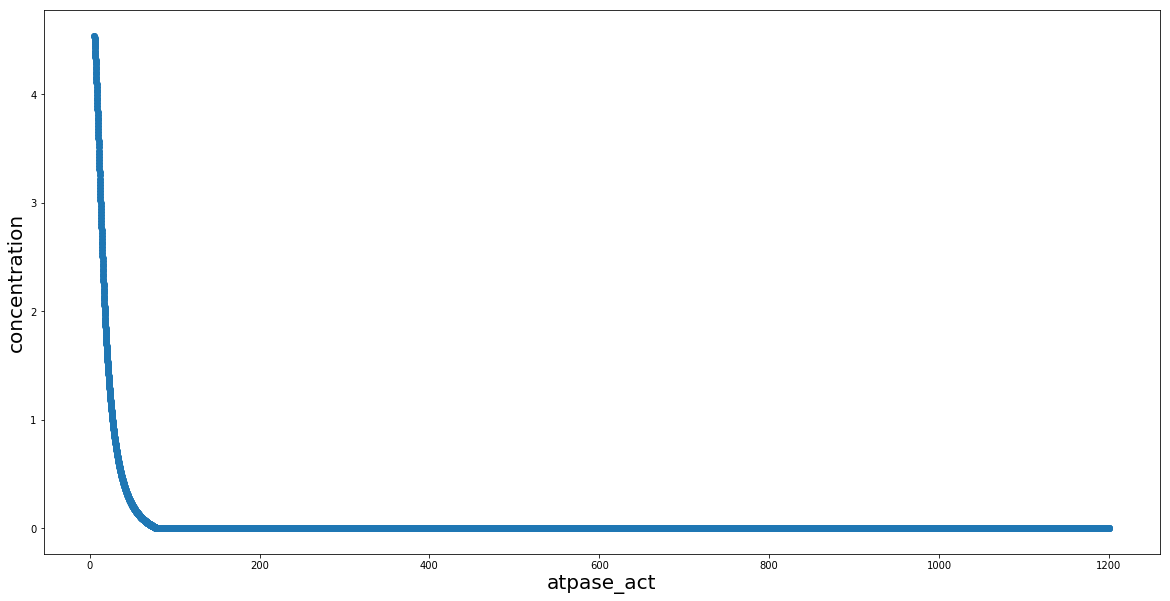

In [857]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act_0, atp_p_0)
#plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

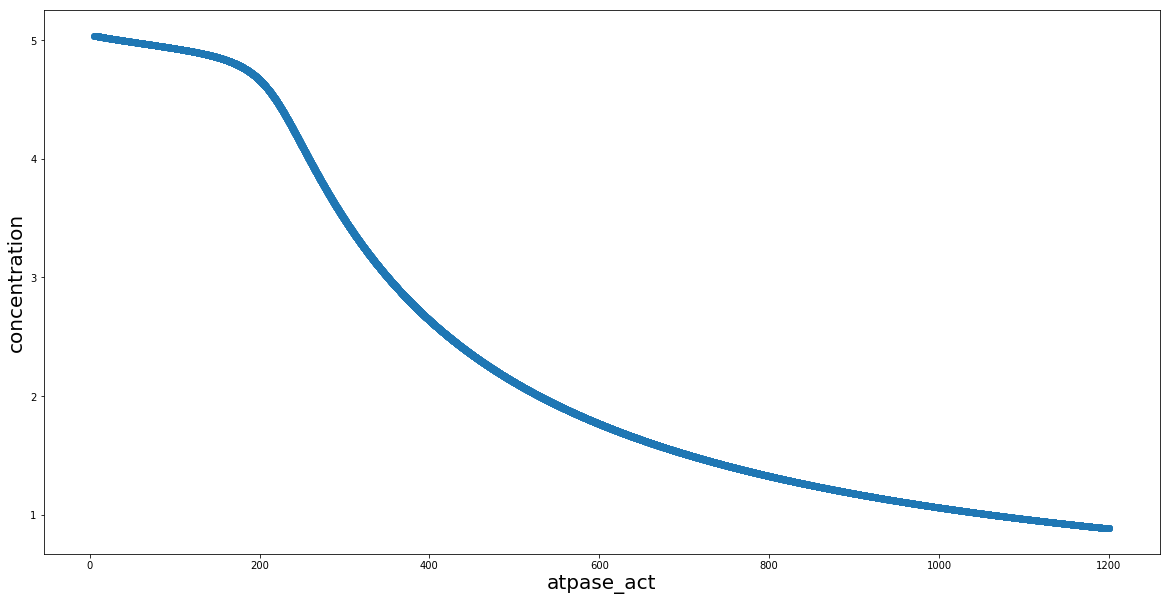

In [858]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act, atp_p)
#plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

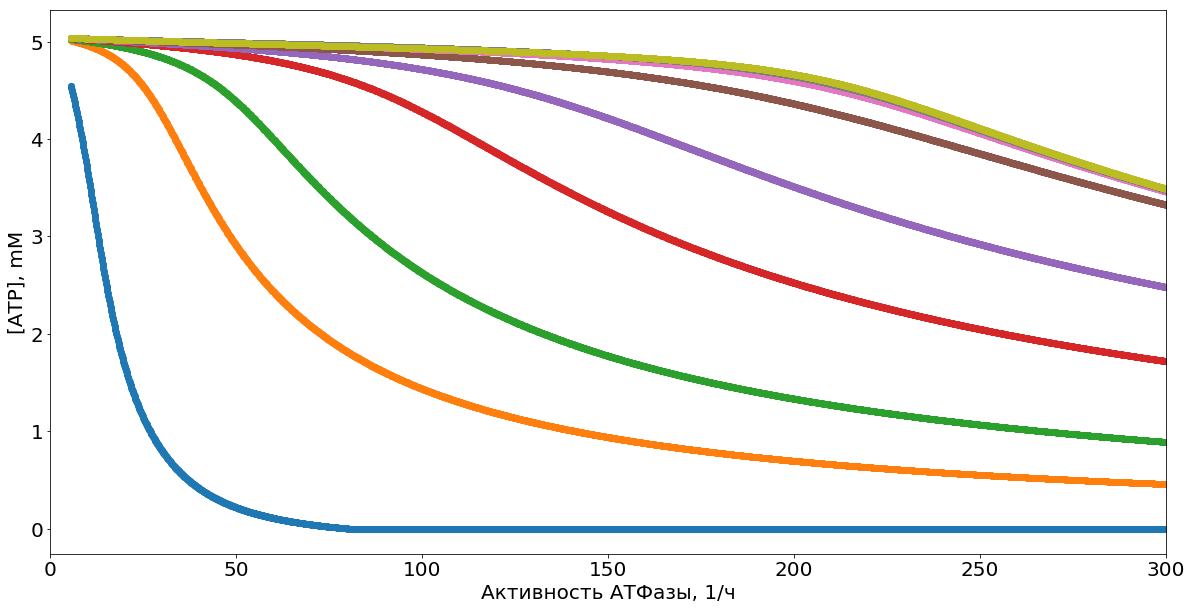

In [859]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act_0, atp_p_0)
plt.scatter(ATPase_act_50, atp_p_50)
plt.scatter(ATPase_act_100, atp_p_100)
plt.scatter(ATPase_act_200, atp_p_200)
plt.scatter(ATPase_act_300, atp_p_300)
plt.scatter(ATPase_act_500, atp_p_500)
plt.scatter(ATPase_act_1000, atp_p_1000)
plt.scatter(ATPase_act_2000, atp_p_2000)
plt.scatter(ATPase_act_5000, atp_p_5000)
#plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('Активность АТФазы, 1/ч', size = 20)
plt.ylabel('[ATP], mM', size = 20)
plt.xlim(0, 300)
plt.xticks(size = 20)
plt.yticks(size = 20)
#plt.ylim(0, 200)
plt.show()

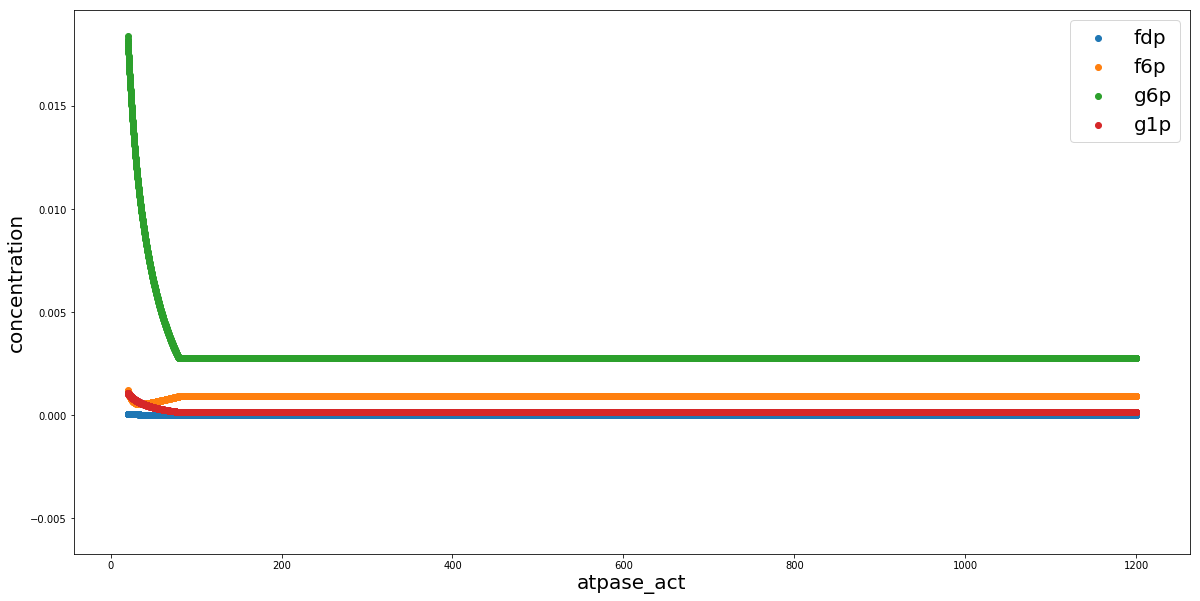

In [424]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act,fdp)
plt.scatter(ATPase_act,f6p)
#plt.scatter(ATPase_act,dap)
#plt.scatter(ATPase_act,gap)
#plt.scatter(ATPase_act,dpg13)
#plt.scatter(ATPase_act,pg3)
#plt.scatter(ATPase_act,pg2)
#plt.scatter(ATPase_act,pep)
#plt.scatter(ATPase_act,nadh)
plt.scatter(ATPase_act,g6p )
plt.scatter(ATPase_act,g1p )
plt.legend(['fdp',\
            'f6p',\
            #'dap',\
            #'gap',\
            #'dpg13',\
            #'pg3',\
            #'pg2',\
            #'pep',\
            #'nadh',\
            'g6p',\
            'g1p'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

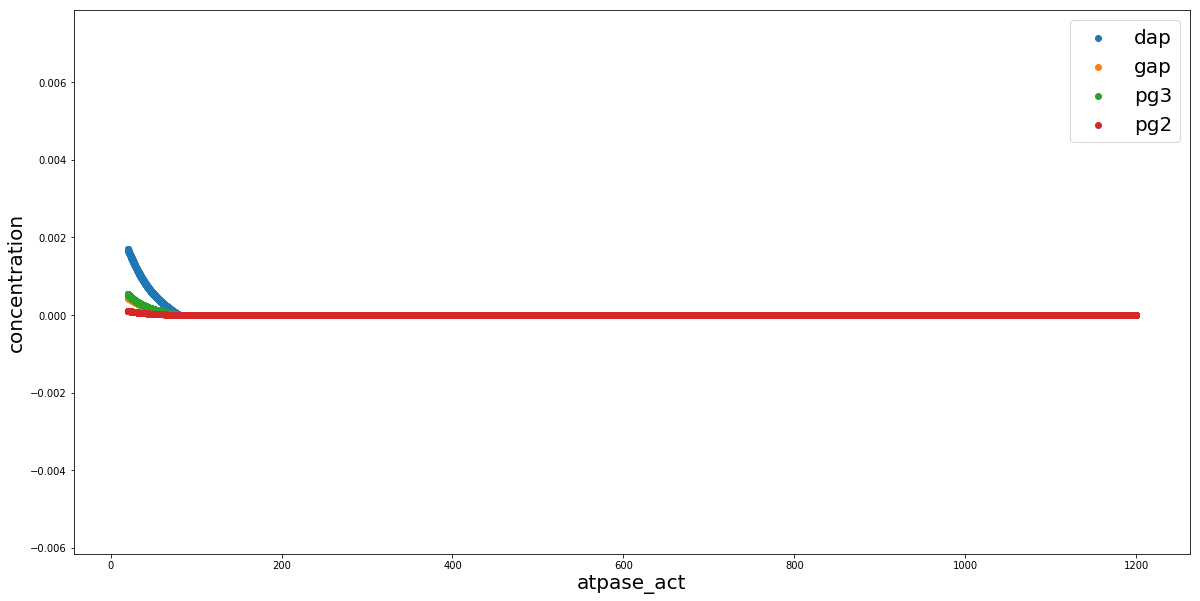

In [37]:
plt.figure(figsize = (20, 10))
#plt.scatter(ATPase_act,fdp)
#plt.scatter(ATPase_act,f6p)
plt.scatter(ATPase_act,dap)
plt.scatter(ATPase_act,gap)
#plt.scatter(ATPase_act,dpg13)
plt.scatter(ATPase_act,pg3)
plt.scatter(ATPase_act,pg2)
#plt.scatter(ATPase_act,pep)
#plt.scatter(ATPase_act,nadh)
#plt.scatter(ATPase_act,g6p )
#plt.scatter(ATPase_act,g1p )
plt.legend([#'fdp',\
            #'f6p',\
            'dap',\
            'gap',\
            #'dpg13',\
            'pg3',\
            'pg2',\
            #'pep',\
            #'nadh',\
            #'g6p',\
            #'g1p'\
], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

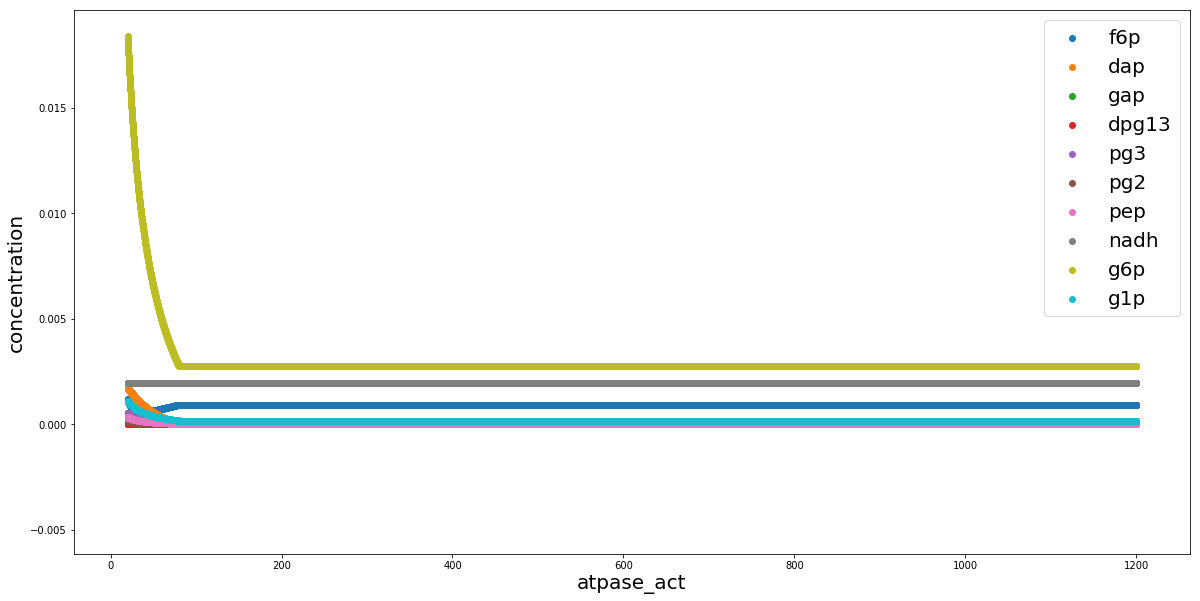

In [38]:
plt.figure(figsize = (20, 10))
#plt.scatter(ATPase_act,fdp)
plt.scatter(ATPase_act,f6p)
plt.scatter(ATPase_act,dap)
plt.scatter(ATPase_act,gap)
plt.scatter(ATPase_act,dpg13)
plt.scatter(ATPase_act,pg3)
plt.scatter(ATPase_act,pg2)
plt.scatter(ATPase_act,pep)
plt.scatter(ATPase_act,nadh)
plt.scatter(ATPase_act,g6p )
plt.scatter(ATPase_act,g1p )
plt.legend([\
            #'fdp', \
            'f6p',\
            'dap',\
            'gap', \
            'dpg13', \
            'pg3', \
            'pg2',\
            'pep',\
            'nadh',\
            'g6p',\
            'g1p'\
           ], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

In [39]:
v_pfk_atp = []
v_hk_atp = []
v_pgk_atp = []
v_pk_atp = []
v_atpase_atp = []
for ix, atp in enumerate(atp_p):
    v_pfk_atp.append(u_pfk(a_pfk, atp, amp_p[ix], f6p[ix]))
    v_hk_atp.append(u_hk(a_hk, atp, g6p[ix]))
    v_pgk_atp.append(u_pgk(a_pgk * ACT, dpg13[ix], adp_p[ix], pg3[ix], atp))
    v_pk_atp.append(u_pk(a_pk * ACT, pep[ix], adp_p[ix], atp))
    v_atpase_atp.append(u_atpase(atpase_act[ix], atp))

In [40]:
v_production_atp = []
for ix, atp in enumerate(atp_p):
    v_production_atp.append(-v_hk_atp[ix] - v_pfk_atp[ix] + v_pgk_atp[ix] + v_pk_atp[ix])

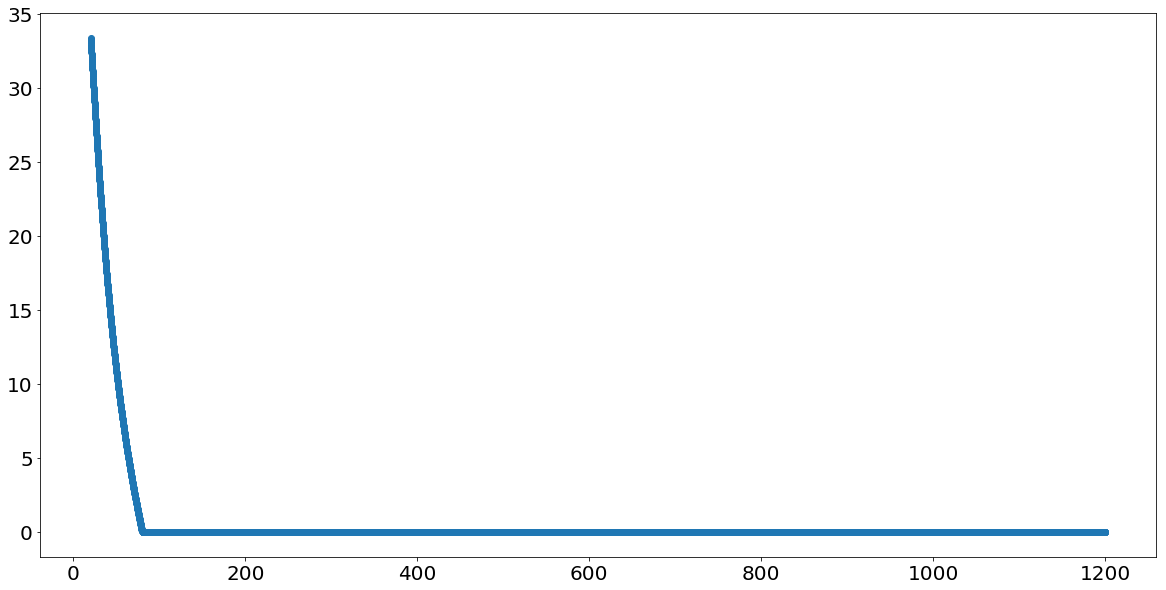

In [41]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act,v_atpase_atp)
#plt.scatter(ATPase_act,v_production_atp)

#plt.legend(['$V_{atpase}$',\
            #'$V_{prod}$'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
#plt.xlabel('ATPase activity', size = 20)
#plt.ylabel('$V_{production}$, mM/h', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
#plt.xlim(0, 400)
#plt.ylim(0, 1200)
plt.show()

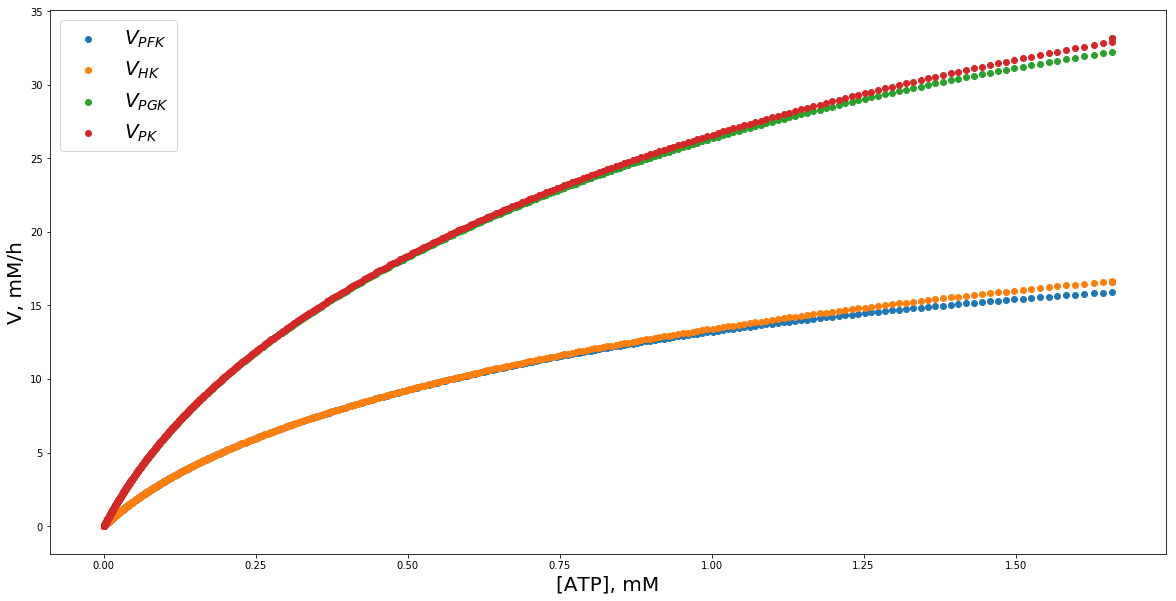

In [42]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,v_pfk_atp)
plt.scatter(atp_p,v_hk_atp)
plt.scatter(atp_p,v_pgk_atp)
plt.scatter(atp_p,v_pk_atp)

plt.legend(['$V_{PFK}$',\
            '$V_{HK}$', \
            '$V_{PGK}$', \
            '$V_{PK}$'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('V, mM/h', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

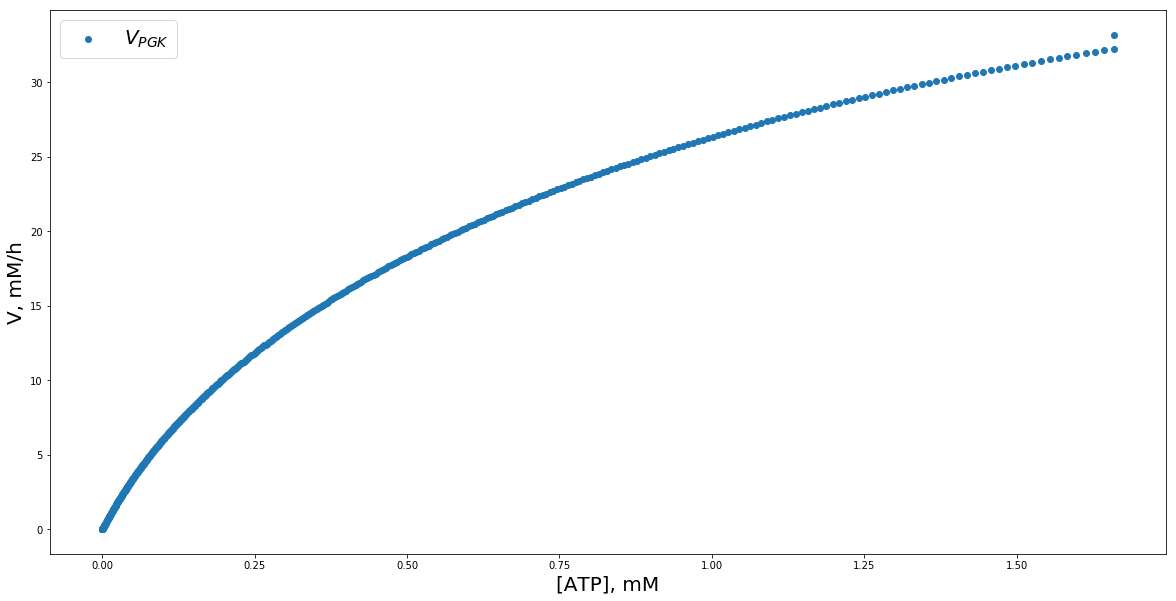

In [43]:
plt.figure(figsize = (20, 10))
#plt.scatter(atp_p,v_pfk_atp)
#plt.scatter(atp_p,v_hk_atp)
plt.scatter(atp_p,v_pgk_atp)
#plt.scatter(atp_p,v_pk_atp)

plt.legend([#'$V_{PFK}$',\
            #'$V_{HK}$', \
            '$V_{PGK}$', \
            #'$V_{PK}$'
], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('V, mM/h', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

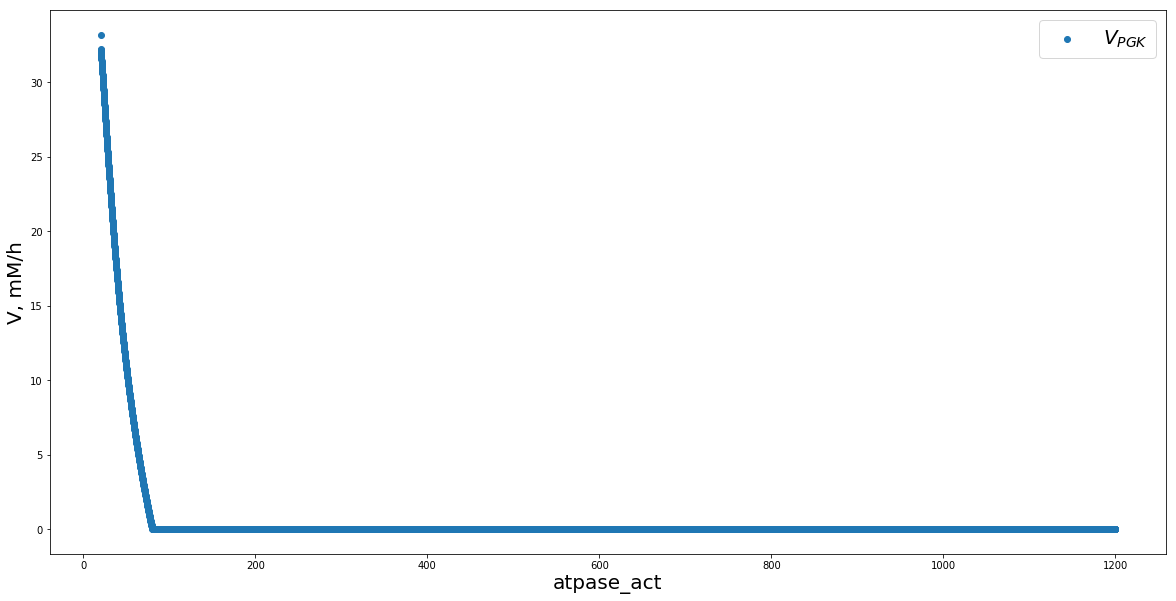

In [44]:
plt.figure(figsize = (20, 10))
#plt.scatter(atp_p,v_pfk_atp)
#plt.scatter(atp_p,v_hk_atp)
plt.scatter(ATPase_act,v_pgk_atp)
#plt.scatter(atp_p,v_pk_atp)

plt.legend([#'$V_{PFK}$',\
            #'$V_{HK}$', \
            '$V_{PGK}$', \
            #'$V_{PK}$'
], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('V, mM/h', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

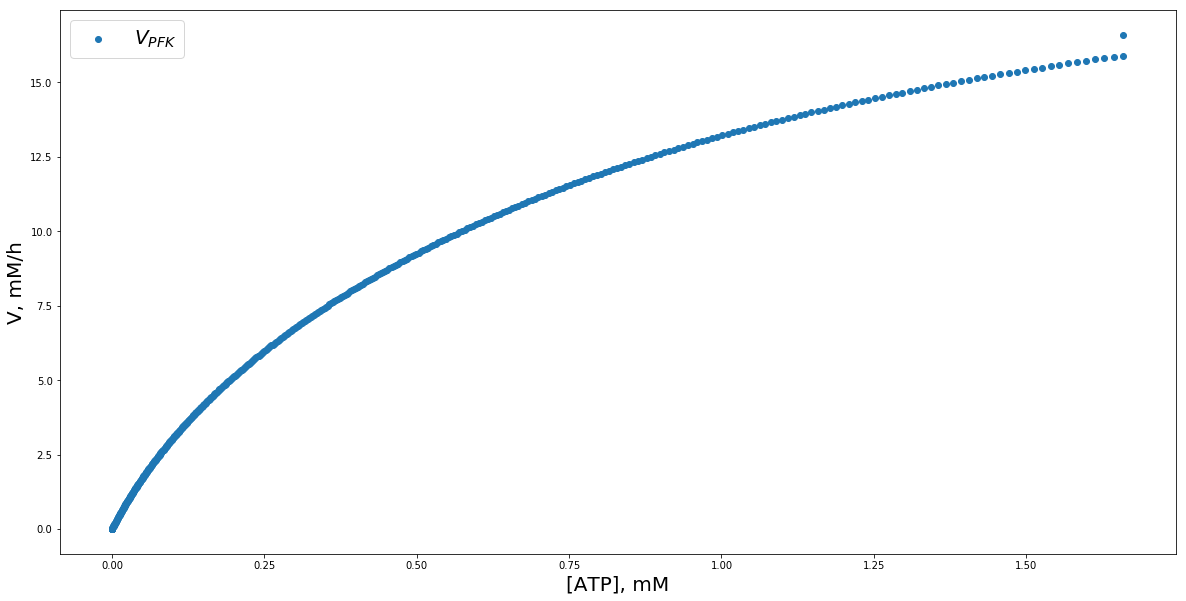

In [45]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,v_pfk_atp)
#plt.scatter(atp_p,v_hk_atp)
#plt.scatter(atp_p,v_pgk_atp)
#plt.scatter(atp_p,v_pk_atp)

plt.legend(['$V_{PFK}$',\
            #'$V_{HK}$', \
            #'$V_{PGK}$', \
            #'$V_{PK}$'
           ], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('V, mM/h', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

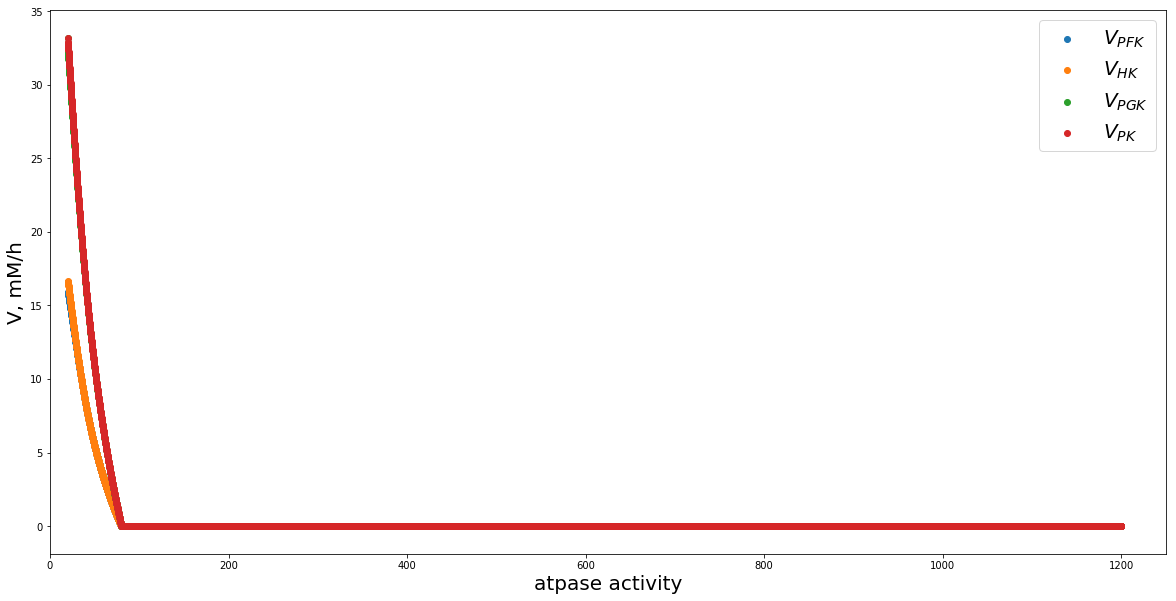

In [46]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act,v_pfk_atp)
plt.scatter(ATPase_act,v_hk_atp)
plt.scatter(ATPase_act,v_pgk_atp)
plt.scatter(ATPase_act,v_pk_atp)

plt.legend(['$V_{PFK}$',\
            '$V_{HK}$', \
            '$V_{PGK}$', \
            '$V_{PK}$'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase activity', size = 20)
plt.ylabel('V, mM/h', size = 20)
plt.xlim(0, 1250)
#plt.ylim(0, 750)
plt.show()

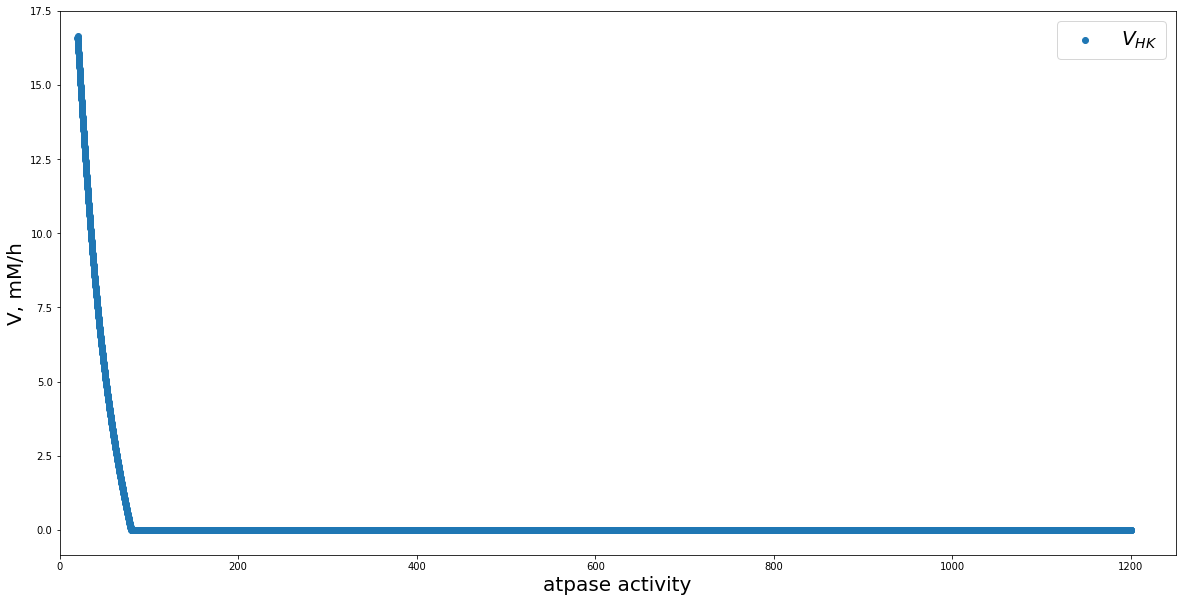

In [47]:
plt.figure(figsize = (20, 10))
#plt.scatter(atpase_act,v_pfk_atp)
plt.scatter(ATPase_act,v_hk_atp)
#plt.scatter(atpase_act,v_pgk_atp)
#plt.scatter(atpase_act,v_pk_atp)

plt.legend([#'$V_{PFK}$',\
            '$V_{HK}$', \
            #'$V_{PGK}$', \
            #'$V_{PK}$'
], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase activity', size = 20)
plt.ylabel('V, mM/h', size = 20)
plt.xlim(0, 1250)
#plt.ylim(0, 6)
plt.show()

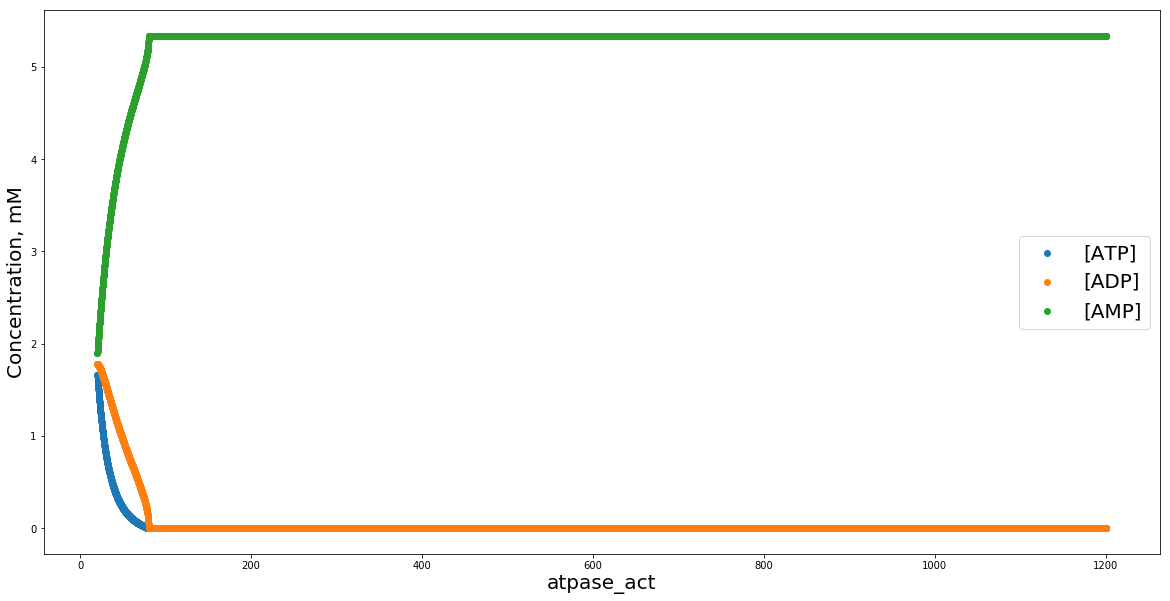

In [48]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act,atp_p)
plt.scatter(ATPase_act,adp_p)
plt.scatter(ATPase_act,amp_p)

plt.legend(['[ATP]',\
            '[ADP]', \
            '[AMP]'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('Concentration, mM', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

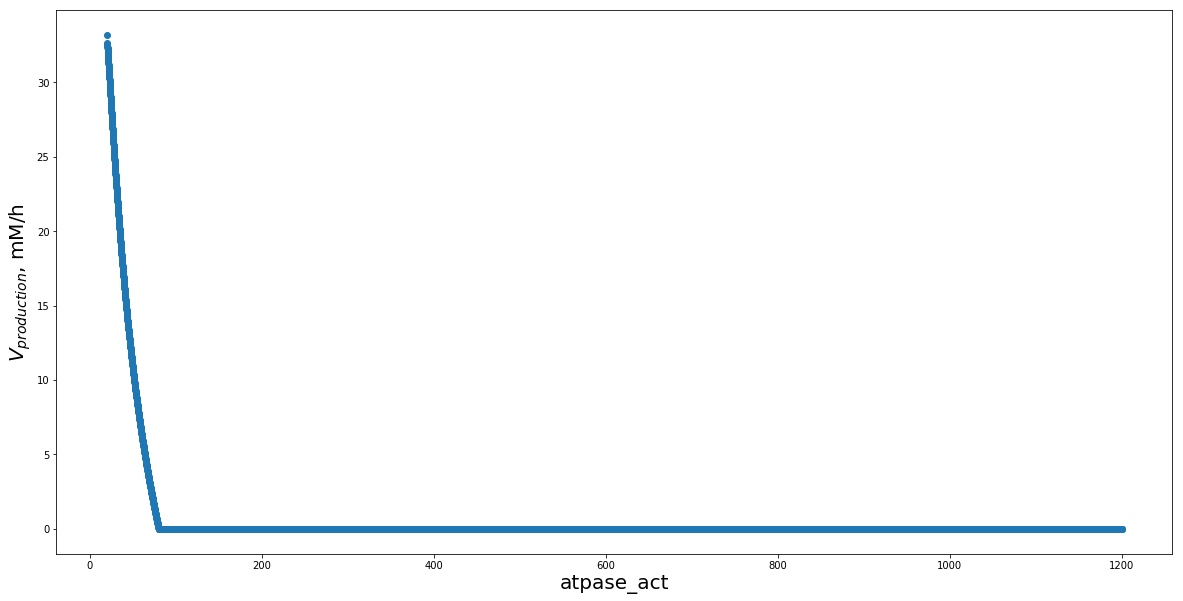

In [49]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act,v_production_atp)

# plt.legend(['[ATP]',\
#             '[AMP]', \
#             '[ADP]'], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('$V_{production}$, mM/h', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

In [461]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

a_gp_a, a_gp_b = 0, 5000
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10
#v_0 = 500

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1


nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [462]:
y0 = [f6p, fdp, dap, gap, dpg13, pg3, pg2, pep, nadh, ep, g6p, g1p]
t = np.linspace(0,120,100000)
res = odeint(right_part,y0,t)

In [463]:
result_gp = [[] for _ in GP_act]
for ix, a_gp_a_ in enumerate(GP_act):
    a_gp_a = a_gp_a_
    result_gp[ix] = odeint(right_part,y0,t)

In [464]:
f6p = np.array(res)[:,0]
fdp = np.array(res)[:,1]
dap = np.array(res)[:,2]
gap = np.array(res)[:,3]
dpg13 = np.array(res)[:,4]
pg3 = np.array(res)[:,5]
pg2 = np.array(res)[:,6]
pep = np.array(res)[:,7]
nadh = np.array(res)[:,8]
ep = np.array(res)[:,9]
g6p = np.array(res)[:,10]
g1p = np.array(res)[:,11]

In [465]:
atp_t = []
adp_t = []
amp_t = []
po4_t = []
crp_t = []
ep_t = []
po4_up_t = []
po4_down_t = []
for i in range(len(t)):
    nad = nad_0 - nadh[i]
    po4_up = g1p[i] + g6p[i] + f6p[i] + 2*fdp[i] + dap[i] + gap[i]
    po4_down = 2*dpg13[i] + pg3[i] + pg2[i] + pep[i]
    po4 = po4_0 - ( po4_up + po4_down + ep[i] )
    crp = float(my_cubic_solve(coefficients(ep[i], c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    atp_t.append(atp)
    adp_t.append(adp)
    amp_t.append(amp)
    po4_t.append(po4)
    crp_t.append(crp)
    ep_t.append(2 * atp + adp + crp)
    po4_up_t.append(po4_up)
    po4_down_t.append(po4_down)

In [466]:
y0_de = [f6p[-1], fdp[-1], dap[-1], gap[-1], dpg13[-1], pg3[-1], pg2[-1], pep[-1], nadh[-1], ep[-1], g6p[-1], g1p[-1]]

In [455]:
GP_act = [0, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]
#GP_act = [0, 5000]

In [456]:
#a_gp_a

In [457]:
result_gp[0][-1]

array([9.17914847e-04, 1.61177588e+01, 1.46595826e+00, 6.59681217e-01,
       5.12932922e-12, 5.09254683e-09, 1.20500858e-09, 5.82464099e-09,
       1.93423599e-03, 1.88023613e-02, 2.75423898e-03, 1.62014058e-04])

In [458]:
atpase_act = np.linspace(20, 1200, 1000)

In [459]:
#res = [[y0_de] for _ in range(len(GP_act))]
res = result_gp
atp_p_gp = [[] for _ in range(len(GP_act))]
adp_p_gp = [[] for _ in range(len(GP_act))]
amp_p_gp = [[] for _ in range(len(GP_act))]
po4_p_gp = [[] for _ in range(len(GP_act))]
ep = ep[-1]
ATPase_act_gp = [[] for _ in range(len(GP_act))]

for a_atpase in atpase_act:
    
    for ix, a_gp_a_ in enumerate(GP_act):
        a_gp_a = a_gp_a_
        nad = nad_0 - res[ix][-1][8]
        po4_up = res[ix][-1][11] + res[ix][-1][10] + res[ix][-1][0] + 2*res[ix][-1][1] + res[ix][-1][2] +res[ix][-1][3]
        po4_down = 2*res[ix][-1][4] + res[ix][-1][5] + res[ix][-1][6] + res[ix][-1][7]
        po4 = po4_0 - ( po4_up + po4_down + res[ix][-1][9] )
        crp = float(my_cubic_solve(coefficients(res[ix][-1][9], c_0, p_0, k_ak, k_ck)))
        atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
        try:
            root = fsolve(func, res[ix][-1], full_output = True)
        except: 
            print('3 roots found :(')
        
        if (root[2] == 1):
            ep = root[0][9]
            np.array(list(res[ix]).append(root[0]))
            ATPase_act_gp[ix].append(a_atpase)
            atp_p_gp[ix].append(atp)
            adp_p_gp[ix].append(adp)
            amp_p_gp[ix].append(amp)
            

3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found :(
3 roots found 

In [460]:
print(0)

0


In [392]:
len(atp_p_gp[0])

991

In [394]:
res[ix][:][9]

array([-2.15513162e-13,  1.61287156e+01,  1.46645676e+00,  6.59905540e-01,
       -2.54457036e-13, -9.71695054e-12, -2.33206813e-12, -1.16603407e-11,
        1.93423598e-03,  3.33243599e-09, -6.46539486e-13, -3.80317345e-14])

In [366]:
# res = [y0_de]
# atp_p = []
# adp_p = []
# amp_p = []
# po4_p = []
# ep = ep[-1]
# for a_atpase in atpase_act:
#     nad = nad_0 - nadh[-1]
#     po4_up = g1p[-1] + g6p[-1] + f6p[-1] + 2*fdp[-1] + dap[-1] + gap[-1]
#     po4_down = 2*dpg13[-1] + pg3[-1] + pg2[-1] + pep[-1]
#     po4 = po4_0 - ( po4_up + po4_down + ep )
#     crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
#     atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
#     root = fsolve(func, res[-1], full_output = True)
#     if (root[2] == 1):
#         res.append(root[0])
#         ep = root[0][9]
#         atp_p.append(atp)
#         adp_p.append(adp)
#         amp_p.append(amp)
#         po4_p.append(po4)
#     else:
#         print(root[3])

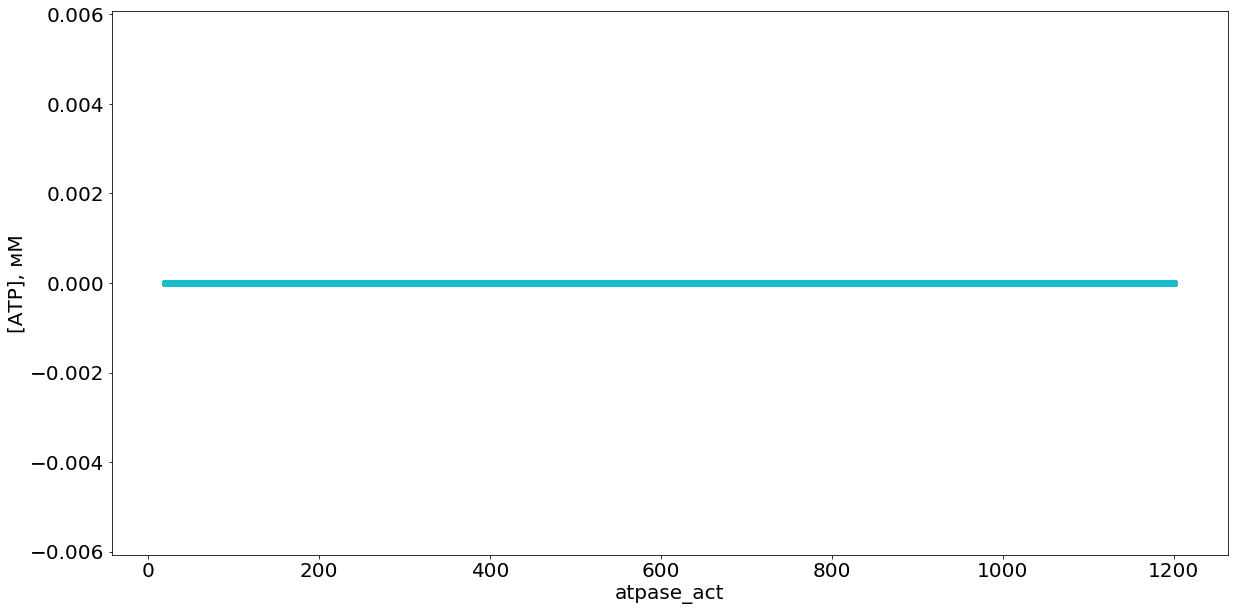

In [367]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act_gp[0],atp_p_gp[0])
plt.scatter(ATPase_act_gp[1],atp_p_gp[1])
plt.scatter(ATPase_act_gp[2],atp_p_gp[2])
plt.scatter(ATPase_act_gp[3],atp_p_gp[3])
plt.scatter(ATPase_act_gp[4],atp_p_gp[4])
plt.scatter(ATPase_act_gp[5],atp_p_gp[5])
plt.scatter(ATPase_act_gp[6],atp_p_gp[6])
plt.scatter(ATPase_act_gp[7],atp_p_gp[7])
plt.scatter(ATPase_act_gp[8],atp_p_gp[8])
plt.scatter(ATPase_act_gp[9],atp_p_gp[9])
# plt.legend([f'GP activity = {GP_act[0]}',\
#             f'GP activity = {GP_act[2]}',\
#             f'GP activity = {GP_act[3]}',\
#             f'GP activity = {GP_act[4]}',\
#             f'GP activity = {GP_act[5]}',\
#             f'GP activity = {GP_act[6]}',\
#             f'GP activity = {GP_act[7]}',\
#             f'GP activity = {GP_act[8]}',\
#             f'GP activity = {GP_act[9]}',\
#             ], fontsize = 20)
#plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atpase_act', size = 20)
plt.ylabel('[ATP], мМ', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
#plt.xlim(0, 300)
#plt.ylim(0, 200)
plt.show()

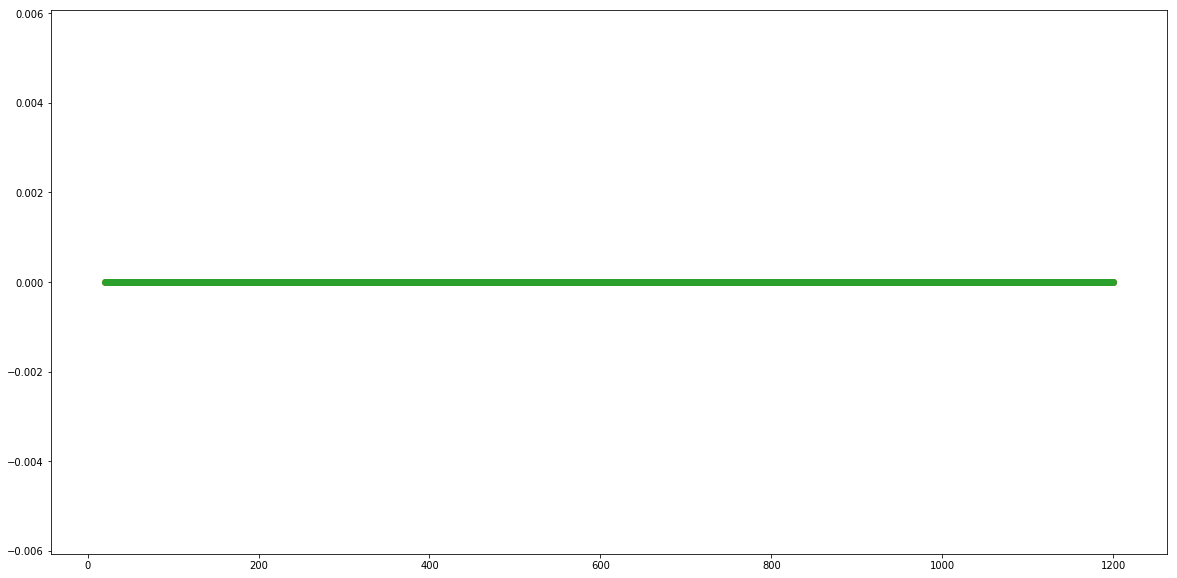

In [368]:
plt.figure(figsize = (20, 10))
plt.scatter(ATPase_act_gp[0],atp_p_gp[0])

plt.scatter(ATPase_act_gp[1],atp_p_gp[1])
plt.scatter(ATPase_act_gp[2],atp_p_gp[2])
plt.show()

In [396]:
import scipy.stats as sps

results = dict()
keys = ['experiment_1', 'experiment_2']
conentrations = {'experiment_1':10,'experiment_2':20}

random_blah_blah = lambda x: sps.randint.rvs(0,10,size = x)

for key_ in keys:
    
    results[key_] = random_blah_blah(conentrations[key_])

In [397]:
results

{'experiment_1': array([3, 4, 4, 0, 1, 3, 6, 5, 9, 1]),
 'experiment_2': array([1, 2, 2, 6, 0, 7, 4, 4, 2, 8, 6, 4, 4, 2, 4, 7, 0, 0, 2, 4])}

In [402]:
def never_use_variables_inside_func(x, ep_):
    
    a_gp_a = x
    
    res = [y0_de]
    atp_p = []
    adp_p = []
    amp_p = []
    po4_p = []
    ep = ep_[-1]
    ATPase_act = []
    for a_atpase in atpase_act:

        nad = nad_0 - res[-1][8]
        po4_up = res[-1][11] + res[-1][10] + res[-1][0] + 2*res[-1][1] + res[-1][2] +res[-1][3]
        po4_down = 2*res[-1][4] + res[-1][5] + res[-1][6] + res[-1][7]
        po4 = po4_0 - ( po4_up + po4_down + ep )
        crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
        atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)

        root = fsolve(func, res[-1], full_output = True)
        if (root[2] == 1):
            res.append(root[0])
            ep = root[0][9]
            atp_p.append(atp)
            adp_p.append(adp)
            amp_p.append(amp)
            po4_p.append(po4)
            ATPase_act.append(a_atpase)

        else:
            print(root[3])
        
    return(res)

agpas = {'0':0, '50':50, '100':100, '200':200,
         '300':300, '400':400, '500':500, '1000':1000, 
         '2000':2000, '5000':5000}

results = dict()

for agpa in agpas:
    results[agpa] = never_use_variables_inside_func(agpas[agpa])

TypeError: never_use_variables_inside_func() missing 1 required positional argument: 'ep_'

In [403]:
never_use_variables_inside_func(0, ep_t)

[[0.0009179148467699885,
  16.11775876602671,
  1.4659582618080196,
  0.6596812171853692,
  5.129329215804053e-12,
  5.0925468269552295e-09,
  1.2050085840336621e-09,
  5.824640987711096e-09,
  0.0019342359854686506,
  0.01880236132689826,
  0.00275423897945619,
  0.00016201405762185446],
 array([5.37378860e-14, 1.61287156e+01, 1.46645676e+00, 6.59905540e-01,
        6.34484846e-14, 9.78085841e-12, 2.34740602e-12, 1.17370301e-11,
        1.93423598e-03, 5.93773469e-10, 1.61213658e-13, 9.48315635e-15]),
 array([5.37378860e-14, 1.61287156e+01, 1.46645676e+00, 6.59905540e-01,
        6.34484846e-14, 9.78085841e-12, 2.34740602e-12, 1.17370301e-11,
        1.93423598e-03, 5.93773469e-10, 1.61213658e-13, 9.48315635e-15]),
 array([5.37378860e-14, 1.61287156e+01, 1.46645676e+00, 6.59905540e-01,
        6.34484846e-14, 9.78085841e-12, 2.34740602e-12, 1.17370301e-11,
        1.93423598e-03, 5.93773469e-10, 1.61213658e-13, 9.48315635e-15]),
 array([5.37378860e-14, 1.61287156e+01, 1.46645676e+00, 